# Evaluasi model R-CNN

In [1]:
# !pip install opencv-contrib-python --upgrade

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
# https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou

In [3]:
model_best = tf.keras.models.load_model('../../models/Esha_R_CNN_3.h5')

In [4]:
val0_files = tf.io.gfile.glob('../../data/training_images_labeled-3/val/0/*.jpg')
val1_files = tf.io.gfile.glob('../../data/training_images_labeled-3/val/1/*.jpg')

val_files = val0_files + val1_files

val_files_wo_path = [x.split('\\')[-1] for x in val_files]

df_val_files = pd.DataFrame(val_files_wo_path,columns=['image'])

df_boundingbox = pd.read_csv('../../data/train_solution_bounding_boxes.csv')
df_boundingbox['xmin'] = df_boundingbox['xmin'].astype('int')
df_boundingbox['xmax'] = df_boundingbox['xmax'].astype('int')
df_boundingbox['ymin'] = df_boundingbox['ymin'].astype('int')
df_boundingbox['ymax'] = df_boundingbox['ymax'].astype('int')

df_boundingbox_m = pd.merge(df_boundingbox, df_val_files, how='inner', on='image')

bb_data = {}

for index,row in df_boundingbox_m.iterrows():
    # filename, xmin, ymin, xmax, ymax = row['image'], int(row['xmin'] * target_w), int(row['ymin'] * target_h), int(row['xmax'] * target_w), int(row['ymax'] * target_h)
    filename, xmin, ymin, xmax, ymax = row['image'], row['xmin'], row['ymin'], row['xmax'], row['ymax']

    if not filename in bb_data:
        bb_data[filename] = [[xmin, ymin, xmax, ymax]]
    else:
        bb_data[filename].append([xmin, ymin, xmax, ymax])

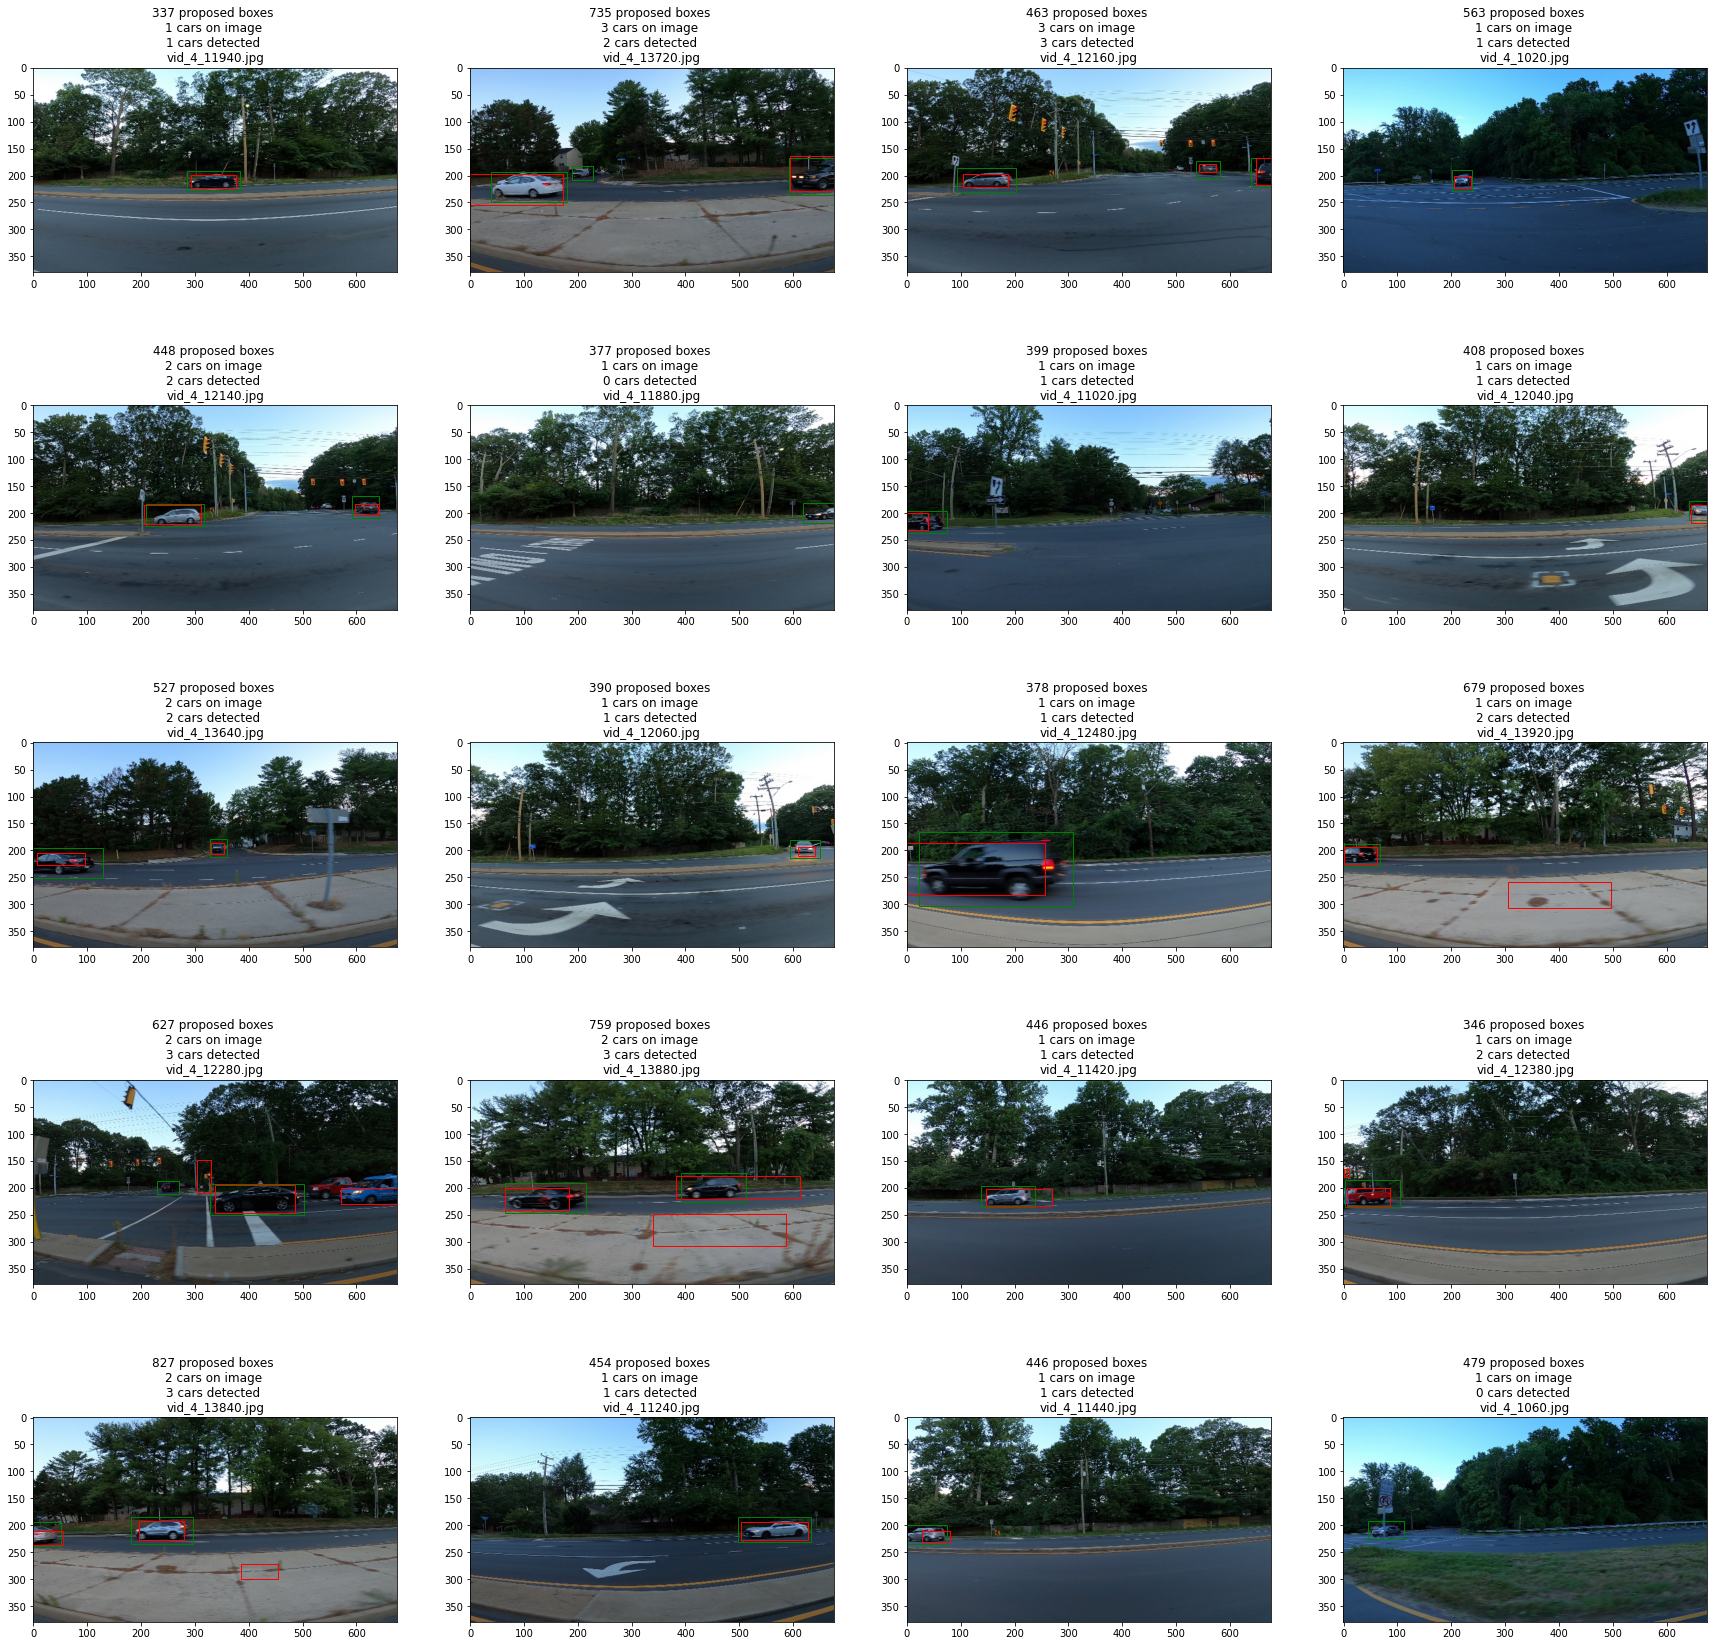

In [8]:
import random

target_size = (224, 224)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
used_image_size = (148,308)
max_proposed_boxes = 2000

samples = random.sample(val1_files,20)

fig, axes = plt.subplots(5,4,figsize=(30,30))
axes = axes.flatten()

ious = []

for i in range(len(samples)):
    filename = samples[i].split('\\')[-1]
    counter = 0
    
    img = load_img(samples[i])
    normalized_img_array = img_to_array(img)
    
    start_h = used_image_size[0]
    end_h = used_image_size[1]
    normalized_img_array = normalized_img_array[start_h:end_h,:,:]

    ss.setBaseImage(normalized_img_array)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    car_boxes = []
    probas = []
    cars = 0

    for (x, y, w, h) in rects:

        if counter <= max_proposed_boxes:
            counter += 1
            filename_box = filename
            proposed_box = [x, y, x + w, y + h]

            image_array = normalized_img_array[proposed_box[1]:proposed_box[3],proposed_box[0]:proposed_box[2]]
            image_array = cv2.resize(image_array,target_size)

            predicted = model_best.predict(image_array.reshape(1,target_size[0],target_size[0],3), verbose=0)

            if np.argmax(predicted) == 1 and predicted[0][1] >= 0.8:
                car_boxes.append([y, x, y + h, x + w])
                probas.append(predicted[0][1])

    pic = plt.imread(samples[i])

    try:
        for b_b in bb_data[filename]:
            xmin, ymin, xmax, ymax = b_b[0], b_b[1], b_b[2], b_b[3]
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')
            axes[i].add_patch(rect)
            ground_box = len(bb_data[filename])
    except:
        ground_box = 0
        pass

    
    if len(probas) > 0:
        selected_indices = tf.image.non_max_suppression(car_boxes, probas, 100, iou_threshold=0.0)
        selected_boxes = tf.gather(car_boxes, selected_indices)

        for j in selected_boxes:
            ymin, xmin, ymax, xmax = j[0], j[1], j[2], j[3]
            ymin, ymax = ymin + start_h, ymax + start_h
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)
            cars += 1

            try:
                for b_b in bb_data[filename]:
                    bounding_box = [b_b[0], b_b[1], b_b[2], b_b[3]]
                    detected_box = [int(xmin), int(ymin), int(xmax), int(ymax)]
                    iou = float(get_iou(bounding_box,detected_box))
                    ious.append([filename, bounding_box, detected_box, iou])
            except:
                pass

    title = str(counter) + ' proposed boxes \n' + str(ground_box) + ' cars on image \n' + str(cars) + ' cars detected \n' + filename
    axes[i].set_title(title)
    axes[i].imshow(pic)